# Training Data Preprocessing

This notebook contains data cleaning and feature engineering for the training data.

#### To-do:

- drop irrelevant columns
- deal with nulls/missing data
- string cleaning of names
- explore combining target classes down to two classes
- rename features

- **REMEMBER TO CONDUCT THE SAME DATA CLEANING TO THE TEST SET AS WELL**


In [63]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from skrub import SimilarityEncoder
from fancyimpute import IterativeImputer

In [64]:
# Importing the custom functions
import sys
import os 
sys.path.append(os.path.abspath('../src'))
from utils import *

In [65]:
# Set max display options so that I can see everything I need to see
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 200)

In [103]:
df = pd.read_csv('../data/processed/training_set_full.csv')

---

In [67]:
# Dropping the columns that are not needed based on my EDA
missing_df = df.drop(columns=['id', 'wpt_name', 'num_private', 'subvillage', 'ward', 'recorded_by', 'scheme_name', 
                            'scheme_management', 'water_quality', 'waterpoint_type_group', 'quantity_group', 'region_code', 
                            'extraction_type', 'extraction_type_group', 'payment', 'source_class', 'source_type'])

---

## Dealing with Missing Values

In [69]:
import missingno as msno

For the purposes of this overview of missing data and the naive approach of dealing with missing values I will be using what is likely going to be the final feature set when doing classifier training. For imputing I will be using the full feature set.

In [ ]:
# Dropping the columns that are not needed based on my EDA
missing_df = df.drop(columns=['id', 'wpt_name', 'num_private', 'subvillage', 'ward', 'recorded_by', 'scheme_name', 
                            'scheme_management', 'water_quality', 'waterpoint_type_group', 'quantity_group', 'region_code', 
                            'extraction_type', 'extraction_type_group', 'payment', 'source_class', 'source_type'])

### Missing data overview

In [70]:
missing_abs = df_train.isna().sum()
missing_abs.sort_values(ascending=False).head(10)

amount_tsh           41639
population           21381
construction_year    20709
gps_height           20438
installer             3655
funder                3637
public_meeting        3334
permit                3056
latitude              1812
longitude             1812
dtype: int64

In [71]:
missing = round((df_train.isna().sum() / len(df_train)) * 100, 2)
missing = missing.sort_values(ascending=False)
missing.head(10)

amount_tsh           70.10
population           35.99
construction_year    34.86
gps_height           34.41
installer             6.15
funder                6.12
public_meeting        5.61
permit                5.14
latitude              3.05
longitude             3.05
dtype: float64

<Axes: >

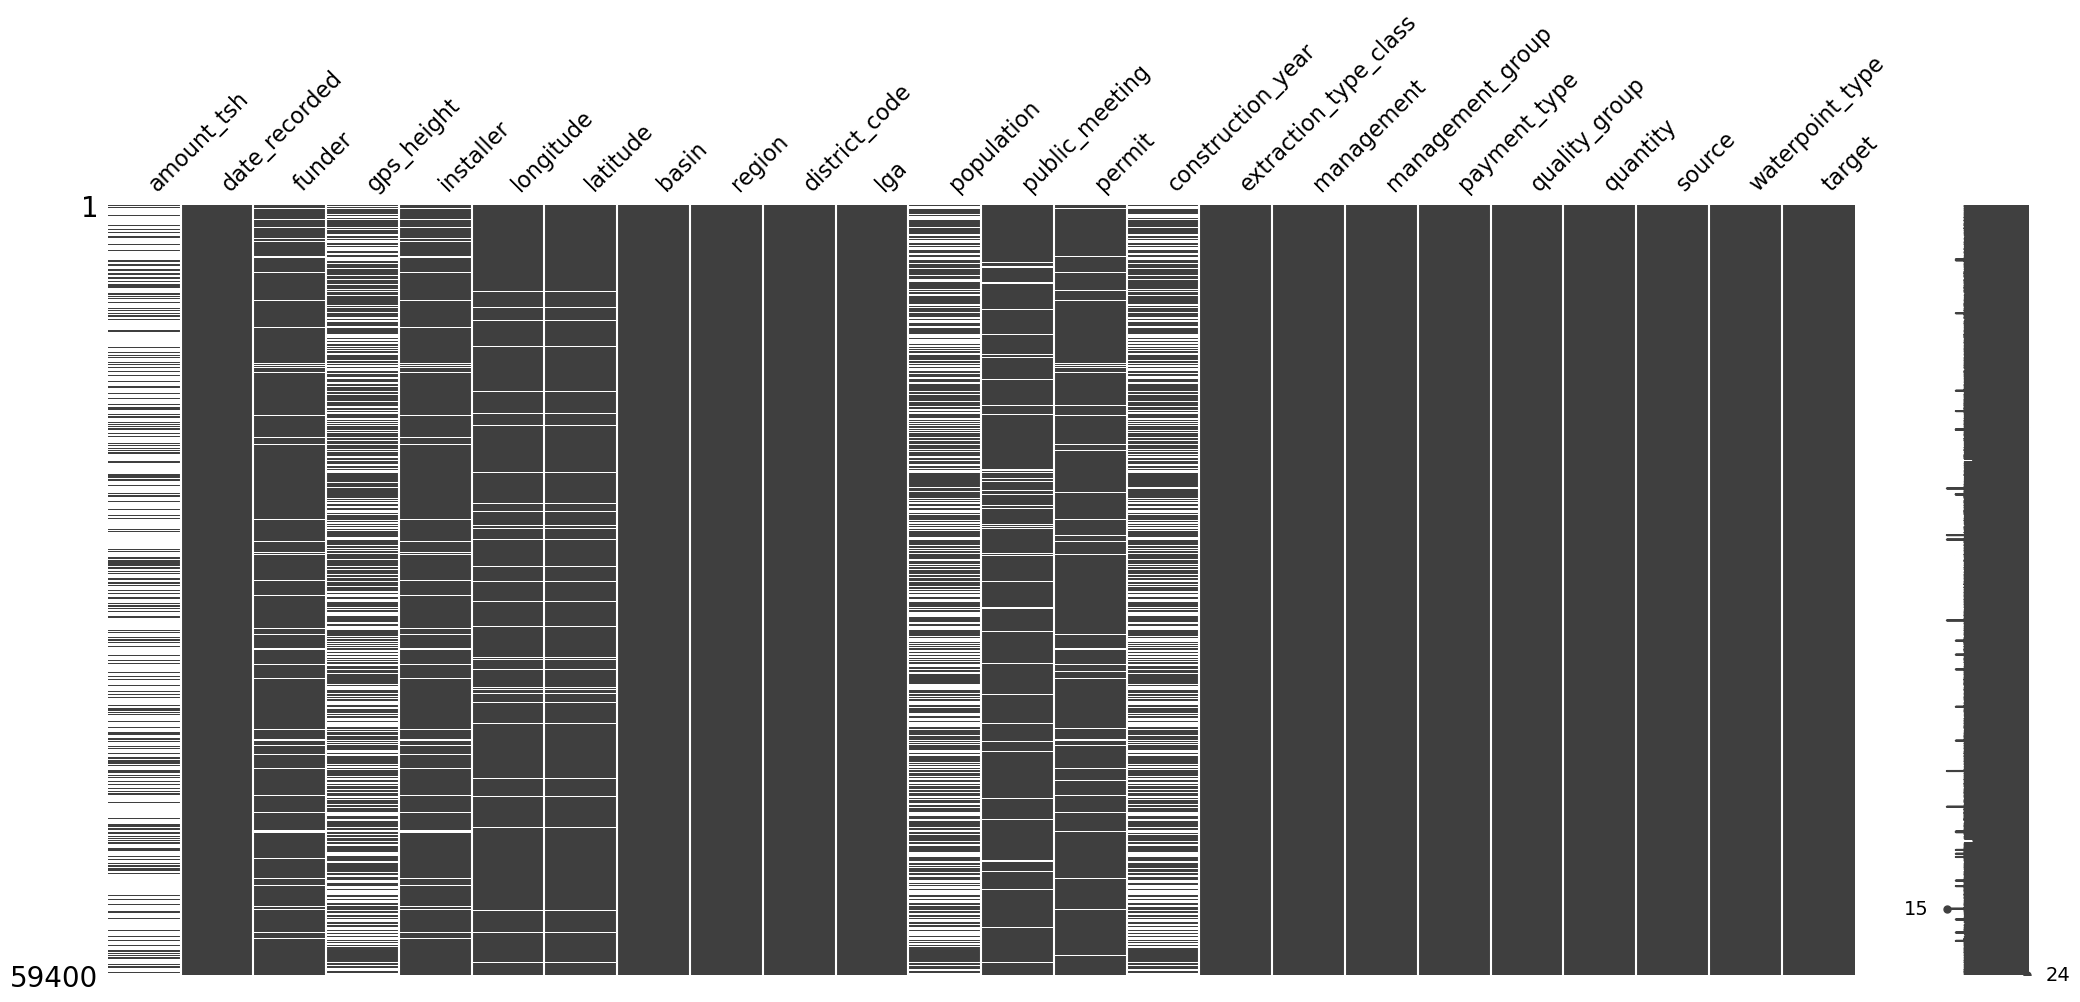

In [72]:
# Visualizing the missing values in the dataset
msno.matrix(df_train)

'population' and 'construction_year' have the highest quantity of missing values and there seems to be a relation between where they are missing in the data. Let's verify this.

<Axes: >

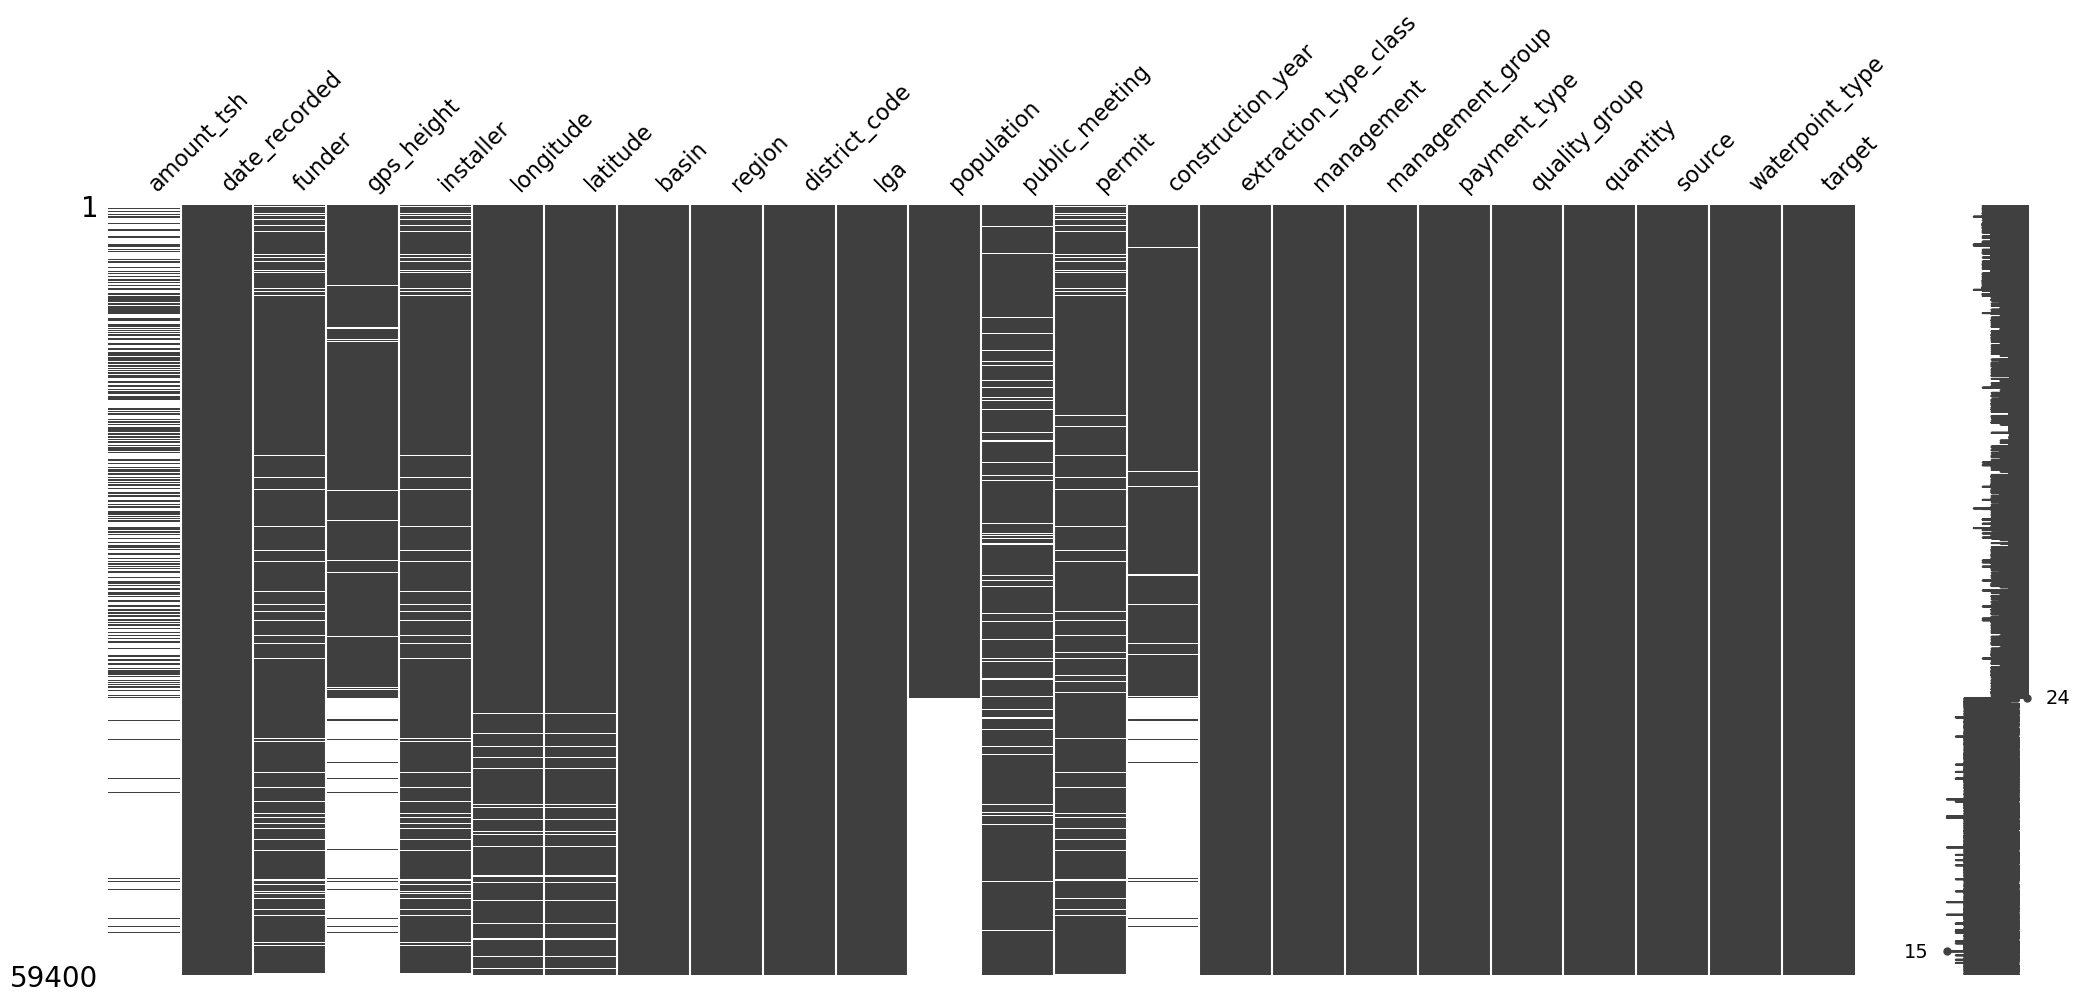

In [73]:
temp = df_train.sort_values('population')
msno.matrix(temp)

There definitely seems to be a discernable pattern in where data is missing in the dataset. 'funder' and 'installer' are missing data on nearly the exact same rows. The same applies to longitude and latitude as I discovered in EDA already. 'population' and 'construction_year' are also missing data in nearly the same exact rows. Now, which strategy to use for dealing with all this missing data?

### Strategy 1: Naive approach - Dropping all records with missing values

The simplest approach is to just drop all nulls.

In [74]:
# Make a copy of df_train to test dropping all nulls
strat1 = df_train.copy()

In [75]:
# amount_tsh has such as a large number of missing values that it is not 
# worth keeping for this approach as too many rows would be dropped along with
# its missing values
strat1 = strat1.drop(columns=['amount_tsh'])

In [76]:
# Drop all null values
strat1 = strat1.dropna()

In [77]:
# 32543 rows left, not bad on a macro level
strat1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32543 entries, 0 to 59399
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date_recorded          32543 non-null  object 
 1   funder                 32543 non-null  object 
 2   gps_height             32543 non-null  float64
 3   installer              32543 non-null  object 
 4   longitude              32543 non-null  float64
 5   latitude               32543 non-null  float64
 6   basin                  32543 non-null  object 
 7   region                 32543 non-null  object 
 8   district_code          32543 non-null  int64  
 9   lga                    32543 non-null  object 
 10  population             32543 non-null  float64
 11  public_meeting         32543 non-null  object 
 12  permit                 32543 non-null  object 
 13  construction_year      32543 non-null  float64
 14  extraction_type_class  32543 non-null  object 
 15  managem

In [78]:
# Export to csv
strat1.to_csv('../data/processed/train_all_nulls_dropped.csv', index=False)

### Strategy 2: Imputation

The naive approach of dropping all missing values can easily lead to important information being lost thus leading to weaker classification models. 

In [81]:
# KDE plot comparing the original and imputed dataset
def impute_checker (feature, imputed_dataset, title):
  df_train[feature].plot(kind='kde', c='black')
  imputed_dataset[feature].plot(kind='kde', style = "--", c= '#66c2a5')
  labels = ['Original df', 'Imputed df']
  plt.legend(labels)
  plt.xlabel(feature)
  plt.title(title)
  plt.show()

#### **MICE imputation**

Testing out MICE imputation.

In [82]:
strat2_train = df_train.copy()

In [83]:
# Drop categorical columns with high cardinality
strat2_train = strat2_train.drop(columns=['funder', 'installer', 'lga', 'region'])

strat2_train_features = strat2_train
# Create a list of all categorical features
categorical_cols = [cname for cname in strat2_train_features.columns if
                    strat2_train_features[cname].dtype == "object"]

In [84]:
# Encode categorical columns 
for col in categorical_cols:
  le = LabelEncoder()
  strat2_train_features[col] = le.fit_transform(strat2_train_features[col])
 

In [85]:
# Create MICE imputer
mice_imputer = IterativeImputer()

# Fit and transform on train
strat2_train_features.iloc[:, :] = (mice_imputer.fit_transform(strat2_train_features))

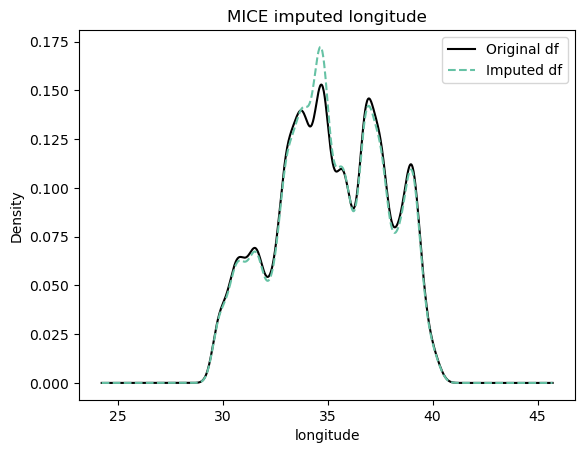

In [86]:
# MICE imputing longitude seems okay
impute_checker('longitude', strat2_train_features, 'MICE imputed longitude')

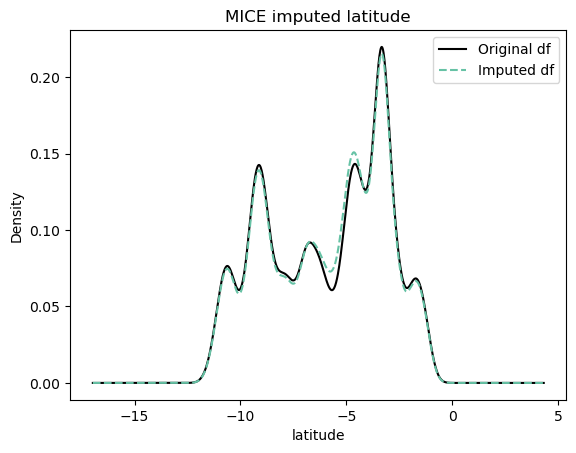

In [87]:
# MICE imputing latitude also seems okay
impute_checker('latitude', strat2_train_features, 'MICE imputed latitude')

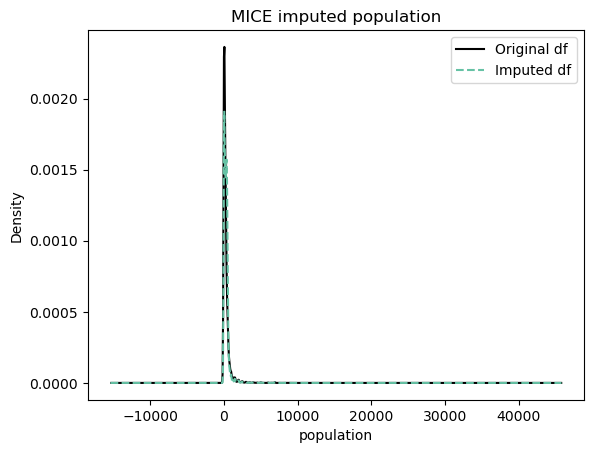

In [88]:
# MICE imputing population is not really achieving the desired effect
impute_checker('population', strat2_train_features, 'MICE imputed population')

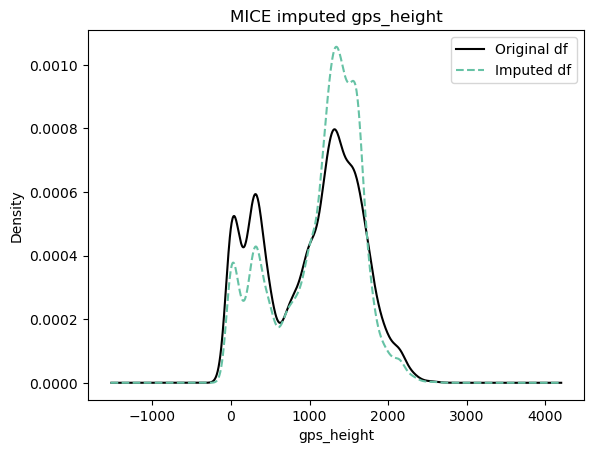

In [89]:
# MICE imputing population is not really achieving the desired effect
impute_checker('gps_height', strat2_train_features, 'MICE imputed gps_height')

MICE imputing missing values in numerical categories looks ok for the coordinates but less effective for 'population' and 'gps_height' introducing a lot of noise. I will not be using these imputations for modeling.

#### **Impute numericals by using nearby samples**

The following helper functions for imputing are borrowed from GitHub user [kochlisGit's](https://github.com/kochlisGit) work on this same dataset.

- <code>impute_zeroes_by_nearby_samples</code>: Imputes a specified column using the mean of nearby located pumps
- <code>find_k_nearest_by_coordinates</code>: Returns the k nearest located pumps, using the longitude and latitude

In [90]:
def find_k_nearest_by_coordinates(
        samples_df: pd.DataFrame,
        k_nearest: int,
        longitude: float,
        latitude: float
) -> pd.DataFrame:
    geo_coordinates = samples_df[['longitude', 'latitude']]
    target_coord = np.float32([longitude, latitude])
    distances = np.sqrt(np.sum(np.power(target_coord - geo_coordinates, 2), axis=1))
    min_distance_indices = np.argpartition(distances, k_nearest)[1: k_nearest+1]
    return samples_df.iloc[min_distance_indices]


def impute_zeros_by_nearby_samples(
        samples_df: pd.DataFrame,
        location_column: str,
        target_column: str,
        std_threshold: float or None
) -> int:
    num_imputed = 0

    for area in samples_df[location_column].unique():
        row_ids = samples_df[location_column] == area
        target_values = samples_df.loc[row_ids, target_column]

        if target_values.shape[0] > 1:
            non_zero_ids = target_values > 0

            if non_zero_ids.sum() > 0:
                non_zero_values = target_values[non_zero_ids]

                if std_threshold is not None and np.std(non_zero_values) > std_threshold:
                    continue

                zero_ids = np.invert(non_zero_ids)
                target_values[zero_ids] = non_zero_values.mean()
                samples_df.loc[row_ids, target_column] = target_values
                num_imputed += zero_ids.sum()
    return num_imputed

#### amount_tsh, population, gps_height

For these imputation methods to work I have to convert the NaN values in my numerical categories back to 0.

In [106]:
# Replace 'np.nan' values in 'construction_year' with 0
df['construction_year'] = df['construction_year'].replace(np.nan, 0)

In [107]:
# Replace np.nan values in 'amount_tsh' with 0
df['amount_tsh'] = df['amount_tsh'].replace(np.nan, 0)

In [109]:
# Replace np.nan values in 'gps_height' with 0
df['gps_height'] = df['gps_height'].replace(np.nan, 0)

In [110]:
# Replace np.nan values in 'population' with 0
df['population'] = df['population'].replace(np.nan, 0)

The 0's that are not imputed remain as 0.

In [111]:
amount_tsh_std_threshold = 50

num_amount_tsh_missing = (df["amount_tsh"] == 0).sum()
num_imputed = impute_zeros_by_nearby_samples(
    samples_df=df,
    location_column='subvillage',
    target_column='amount_tsh',
    std_threshold=amount_tsh_std_threshold
)
print(f'Imputed {num_imputed}/{num_amount_tsh_missing} missing "amount_tsh" values')

'Imputed 4573/41639 missing "amount_tsh" values'

In [113]:
population_std_threshold = 50

num_amount_tsh_missing = (df["population"] == 0).sum()
num_imputed = impute_zeros_by_nearby_samples(
    samples_df=df,
    location_column='subvillage',
    target_column='population',
    std_threshold=population_std_threshold
)
print(f'Imputed {num_imputed}/{num_amount_tsh_missing} missing "population" values')

'Imputed 1363/21381 missing "population" values'

In [115]:
location_columns = ['subvillage', 'ward', 'lga', 'district_code']

for location_column in location_columns:
    num_gps_height_missing = (df["gps_height"] == 0).sum()
    num_imputed = impute_zeros_by_nearby_samples(
        samples_df=df,
        location_column=location_column,
        target_column='gps_height',
        std_threshold=None
    )
    print(f'Imputed {num_imputed}/{num_gps_height_missing} missing "gps_height"')

Imputed 5354/20438 missing "gps_height"
Imputed 13933/15804 missing "gps_height"
Imputed 2558/2604 missing "gps_height"
Imputed 89/89 missing "gps_height"


In [117]:
k_neighbors = 25
gps_height_zero_ids = df['gps_height'] == 0
gps_zero_samples = df[gps_height_zero_ids]
gps_heights = []

for _, sample in gps_zero_samples.iterrows():
    longitude = df['longitude']
    latitude = df['latitude']
    nearest_samples = find_k_nearest_by_coordinates(
        samples_df=df,
        k_nearest=k_neighbors,
        longitude=longitude,
        latitude=latitude
    )
    non_zero_gps_height_values = nearest_samples.loc[nearest_samples['gps_height'] != 0, 'gps_height']
    gps_heights.append(non_zero_gps_height_values.mean())

df.loc[df['gps_height'] == 0, 'gps_height'] = gps_heights
print(f'gps_height == 0: {(df["gps_height"] == 0).sum()} After K-NN method')

'gps_height == 0: 0 After K-NN method'

#### **Impute categoricals by using nearby samples** [future project]

### Strategy 3: Combination of strategies 1 and 2 [future project]

A little more finesse than only dropping nulls or only imputing all missing values.

---

## Feature Engineering on the Remaining Features

Before modeling, the rest of the features could also use a bit of modification.

#### **permit and public_meeting**

Encoding these two boolean categories.

In [119]:
# Encoding the booleans in these two categories to 0 (False)m 1(True), and -1 (NaN) 
df['public_meeting'] = df['public_meeting'].fillna('Unknown')
df['public_meeting'] = df['public_meeting'].replace({'False': 0, 'True': 1, 'Unknown': -1})

df['permit'] = df['permit'].fillna('Unknown')
df['permit'] = df['permit'].replace({'False': 0, 'True': 1, 'Unknown': -1})

#### **Creating a pump_age feature**

The features 'construction_year' and 'date_recorded' can be used to create a feature that tells us the duration a pump has been in operation. However, 'construction_year' has a lot of missing values. In such cases I'll set pump_age to -1.

In [121]:
# Creating a new feature that represents the age of the pump
df['construction_year'] = df['construction_year'].replace(0, 10000) # Replacing 0 with 10000 to capture invalid pump ages
df['pump_age'] = pd.DatetimeIndex(df['date_recorded']).year - df['construction_year']

invalid_pump_age = df['pump_age'] < 0
df.loc[invalid_pump_age, 'pump_age'] = -1 

#### **Creating a time recorded feature with lower dimensionality 'season'**

Insteaf of date recorded or even month recorded I'll condense it down to seasons I discovered while doing EDA - essentially a split between rainy and dry seasons.

- ShortDry: January-February
- LongRainy: March-May
- LongDry: June-October
- ShortRainy: November-December

In [127]:
# Dictionary matching months to their corresponding seasons
# 0: ShortDry, 1: LongRainy, 2: LongDry, 3: ShortRainy
seasons = {
    1: 0, 2: 0,
    3: 1, 4: 1, 5: 1,
    6: 2, 7: 2, 8: 2, 9: 2, 10: 2,
    11: 3, 12: 3,
}

# Creating the 'season' column
df['season'] = pd.DataFrame({'Month': pd.DatetimeIndex(df['date_recorded']).month})
df['season'] = df['season'].apply(lambda month: seasons[month])

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  float64
 5   installer              55745 non-null  object 
 6   longitude              57588 non-null  float64
 7   latitude               57588 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

## Target Variable: From 3 Classes to 2

As mentioned in EDA, there is a vast class imbalance among the target variable with 'functional needs repair' being the smallest class by far. To avoid some of the issues associated with this kind of an imbalance and to get a more robust model for predicting water pump functionality I'll be merging the smallest class into one of the big classes.

In [131]:
# Class imbalance in target variable
df['target'].value_counts()

target
functional                 32259
non functional             22824
functional needs repair     4317
Name: count, dtype: int64

I'll take the naive approach of merging 'functional needs repair' into 'non functional'. It is reasonable to consider water pumps that are functional but need repairing to be not fully functional. Both need attention from whoever is doing the maintenance on these pumps. Therefore I'll be re-classifying 'functional needs repair' as 'non functional'. 

In [132]:
# Replace 'functional needs repair' with 'non functional'
df['target'] = df['target'].replace('functional needs repair', 'non functional')

In [135]:
# Export to csv file
df.to_csv('../data/final/training_cleaned.csv', index=False)